# **Цель исследование:**

Необходимо создать классификационную модель 100 видов спорта, а также метод загрузки сторонних изображений и проверки на корректность классификации

Загрузка необходимых библиотек

In [1]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize,Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18,vgg16
from torch import nn
from torch.nn import Linear, Conv2d, MaxPool2d, ReLU, Dropout
from torch.optim import Adam
import torch
from sklearn.metrics import classification_report
import os

import matplotlib.pyplot as plt

Данные были взяты из kaggle. Я загрузила их себе на гугл-диск, чтобы легче было с ними работать

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка данных с нормализацией, так как в дальнейшем будут использованы нейронные сети, для которых необходимо проанализировать графики

In [3]:
train_data=ImageFolder("/content/drive/My Drive/kaggle/archive/train",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
test_data=ImageFolder("/content/drive/My Drive/kaggle/archive/test",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
valid_data=ImageFolder("/content/drive/My Drive/kaggle/archive/valid",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))

Как выглядит один пример данных

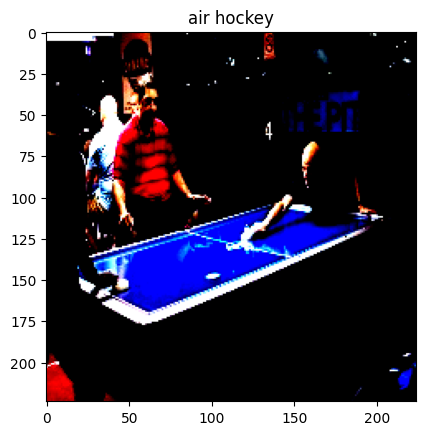

In [4]:
for i,j in valid_data:
    plt.title(valid_data.classes[j])
    plt.imshow(i.permute(1,2,0))
    break

Последняя подготовка данных: создание загрузчика данных

In [5]:
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=16,shuffle=True)
val_loader=DataLoader(valid_data,batch_size=16)

In [6]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


### Обучение трех моделей

**1. Собственная нейронная сеть**

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.drop = Dropout(0.2)
        self.fc1 = nn.Linear(32*56*56, 1000) # 224/2/2 = 56
        self.fc2 = nn.Linear(1000, 100)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Ниже есть возможность загрузить уже обученная модель

In [ ]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_наша.pth")
model = MyCNN()
model.load_state_dict(model_dict)
clf = model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

**2. Vgg16 - существующая модель для классификации, но до обученная под мою задачу**

In [ ]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_vgg16.pth")
vgg_model=vgg16(pretrained=True) #или вместо vgg16 - resnet18
vgg_model.fc=nn.Linear(512,len(train_data.classes))
vgg_model.load_state_dict(model_dict)
clf = vgg_model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.3MB/s]


**2. Resnet18 - существующая модель для классификации, но до обученная под мою задачу**

In [7]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_resnet18.pth")
resnet_model=resnet18(pretrained=True)
resnet_model.fc=nn.Linear(512,len(train_data.classes))
resnet_model.load_state_dict(model_dict)
clf = resnet_model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Ниже приведен код обученния модели

In [ ]:
for e in range(10):
    clf.train()
    loss_total=[]
    step = 0
    for X,y in train_loader:
        step += 1
        X,y=X.to(device_name),y.to(device_name)
        yhat=clf(X)
        loss=loss_fn(yhat,y)
        loss_total.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(f"{step}/ {len(train_loader)}")

    print(f"Epoch {e} loss {sum(loss_total)/len(loss_total)}")
    torch.save(model.state_dict(), 'model_weights.pth')
    step = 0
    clf.eval()
    val_loss=[]
    with torch.no_grad():
        for X,y in val_loader:
            step += 1
            X,y=X.to(device_name),y.to(device_name)
            yhat=clf(X)
            loss=loss_fn(yhat,y)
            val_loss.append(loss)
            print(f"{step}/ {len(val_loader)}")

        print(f"val loss {sum(val_loss)/len(val_loss)}")

Предсказание результатов

In [8]:
ypreds=[]
yy=[]
clf.eval()
step = 0
with torch.no_grad():
    for X,y in test_loader:
        step += 1
        X,y=X.to(device_name),y.to(device_name)
        yhat=clf(X)
        pred=torch.argmax(yhat,1)
        ypreds.extend(pred.cpu())
        yy.extend(y.cpu())
        print(f"{step}/ {len(test_loader)}")

print(classification_report(ypreds,yy))

1/ 14
2/ 14
3/ 14
4/ 14
5/ 14
6/ 14
7/ 14
8/ 14
9/ 14
10/ 14
11/ 14
12/ 14
13/ 14
14/ 14
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         0
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


В результате анализа трех моделей лучший результат дала - **resnet18**. Именно поэтому для предсказания далее будет использована она

### **Предсказание с помощью фотографий из интернета**

Создаем список видов спорта, а также их номеров для проверки корректности предсказывания

In [ ]:
class_names=sorted(os.listdir('/content/drive/My Drive/kaggle/archive/train'))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
normal_mapping

In [ ]:
# Сначала загрузите изображение с помощью OpenCV
image = cv2.imread('7.jpg')  # Сначала загрузите изображение из интернета с помощью OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Преобразуйте изображение из BGR в RGB
image = torch.from_numpy(image) # Преобразуйте изображение в тензор

# Преобразование размера изображения
image_resized = F.interpolate(image.permute(2, 0, 1).unsqueeze(0).float(), size=224, mode='bilinear', align_corners=False)
# print(image_resized.shape)
# Нормализация изображения
normalize = transforms.Compose([
    transforms.Normalize(mean=[485, 456, 406], std=[229, 224, 225])
])

#[0.485, 0.456, 0.406],[0.229, 0.224, 0.225] или возможно необохима будет такая нормализация

image_normalized = normalize(image_resized.squeeze())

print(image_normalized.shape)  # Распечатает размер тензора после изменения размера и нормализации

image_tensor = image_normalized.unsqueeze(0)
print(image_tensor.shape) # добавление измерения пакета, размер станет [1, 3, 224, 224]

clf.eval()
with torch.no_grad():
    image_tensor= image_tensor.to(device_name)
    yhat=clf(image_tensor)
    pred=torch.argmax(yhat,1)
print(pred)

**Вывод:**

В ходе исследования были проанализированы три модели. Лучший показатели качества показала уже существующая ранее модель - resnet18. Этот результат говорит о том, что при классификации изображений необходимо подстраиваться под различные задачи и где это возможно использовать уже раннее созданные для облегчения производства далее.

Также был создан код, который позволяет анализировать сторонние фотографии
